<a href="https://colab.research.google.com/github/kyg1225/finalProject/blob/master/%EA%B9%80%EC%97%AC%EA%B2%BD_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EA%B8%B0%EB%A7%90%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020학년도 2학기 머신러닝 기말과제



* 목적: 텍스트의 긍정/부정 예측을 위한 머신러닝 모델 학습하기
* 미션: 아래 샘플 코드를 수정하여 평가데이터에 대한 예측 성능을 최대로 하시오.



In [1]:
!pip install konlpy

In [2]:
######### 수정 금지 ###########
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
######### 수정 금지 ###########

# 데이터 로드하기


1.  학습데이터에 해당하는 ratings_train.txt와 평가데이터에 해당하는 ratings_test.txt를 다운로드합니다.
2.   Pandas를 이용하여 학습데이터는 train_data에 평가데이터는 test_data에 저장합니다.



In [3]:
######### 수정 금지 ###########
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print('학습용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('평가용 리뷰 개수 :',len(test_data)) # 훈련용 리뷰 개수 출력
######### 수정 금지 ###########

학습용 리뷰 개수 : 150000
평가용 리뷰 개수 : 50000


# 데이터 확인

1. 해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다.
2. 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 이용합니다.

In [4]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 정제하기

1. 온점(.)이나 ?와 같은 각종 특수문자를 정규표현식을 사용하여 제거합니다.
2. 특수문자로만 구성된 데이터의 경우 빈 값만 남으므로 해당 샘플은 제거합니다.

In [5]:
######### 수정 금지 ###########
train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 학습용 샘플의 개수 :',len(train_data))
######### 수정 금지 ###########

전처리 후 학습용 샘플의 개수 : 145791


In [6]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 평가용 샘플의 개수 :',len(test_data))

전처리 후 평가용 샘플의 개수 : 48995


# 데이터 토큰화

1. 형태소 분석기(okt)를 통해 어절을 형태소로 분리한 다음 불필요한 형태소를 제거합니다.

In [7]:
######### 수정 금지 ###########
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
print(X_train[:3])
######### 수정 금지 ###########

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [8]:
######### 수정 금지 ###########
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
print(X_test[:3])    
######### 수정 금지 ###########

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


# 데이터 인코딩

1. 형태소로 이루어진 데이터를 정수로 인코딩합니다.
2. 빈도가 낮은 단어는 샘플에서 삭제할 수도 있습니다.

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [10]:
### threshold= 2 -> 3 바꿈
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [11]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [12]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [14]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


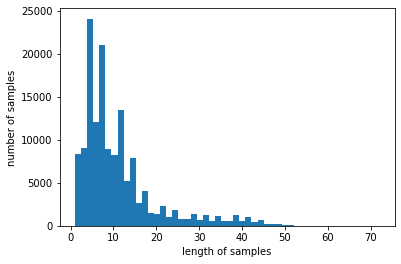

In [15]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

### 샘플 최대 길이 30으로 변경
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [17]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [18]:
#Embedding, LSTM, load_model, EarlyStopping, ModelCheckpoint 추가

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# 단어 임베딩 해주기, 한번에 임베딩할 단어 수 100개, rnn모델인 LSTM으로 수정
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [21]:
### 학습이 더이상 되지 않는 순간을 대비해 모델을 빨리 멈추는 얼리 스타핑 추가
es = EarlyStopping()

### 처음부터 모델을 저장하는데 괜찮은 모델이 생성되었을때만 갱신
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_acc',
                     mode='max', verbose=1,
                     save_best_only=True)

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=15,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 26s 11ms/step - loss: 0.4387 - acc: 0.7908 - val_loss: 0.3526 - val_acc: 0.8457

Epoch 00001: val_acc improved from -inf to 0.84568, saving model to best_model.h5
Epoch 2/15
1939/1939 [==============================] - 20s 10ms/step - loss: 0.3289 - acc: 0.8564 - val_loss: 0.3350 - val_acc: 0.8541

Epoch 00002: val_acc improved from 0.84568 to 0.85414, saving model to best_model.h5
Epoch 3/15
1939/1939 [==============================] - 19s 10ms/step - loss: 0.3017 - acc: 0.8725 - val_loss: 0.3287 - val_acc: 0.8593

Epoch 00003: val_acc improved from 0.85414 to 0.85933, saving model to best_model.h5
Epoch 4/15
1939/1939 [==============================] - 19s 10ms/step - loss: 0.2833 - acc: 0.8826 - val_loss: 0.3297 - val_acc: 0.8618

Epoch 00004: val_acc improved from 0.85933 to 0.86181, saving model to best_model.h5


In [23]:
### 저장된 모델 중 베스트 모델을 불러와 평가
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3388 - acc: 0.8545

 테스트 정확도: 0.8545


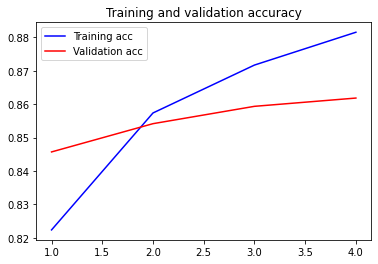

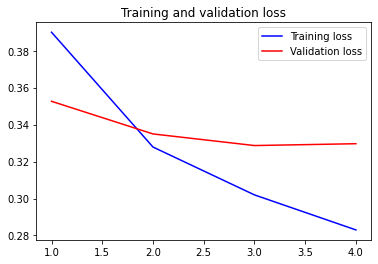

In [24]:
### 학습과정에 대해 그래프로 확인
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()